In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import warnings
from sklearn.metrics import mean_squared_error
import optuna

In [17]:
warnings.filterwarnings("ignore")
%matplotlib inline

In [18]:
dataset_map = {'1': 'Energy', '2': 'Stock', '3': 'Traffic', '4': 'Weather'}
dataset_choice = input("Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather): ")
selected_dataset = dataset_map.get(dataset_choice)

Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather):  2


In [19]:
base_models = ['LSTM', 'Transformer', 'LiquidML', 'XGBoost']
selected_models = []
for model in base_models:
    choice = input(f"Include {model} in ensemble? (y/n): ")
    if choice.lower() == 'y':
        selected_models.append(model)

Include LSTM in ensemble? (y/n):  y
Include Transformer in ensemble? (y/n):  y
Include LiquidML in ensemble? (y/n):  y
Include XGBoost in ensemble? (y/n):  y


In [20]:
dataset_files = {
    'Energy': 'datasets/AEP_hourly_processed.xlsx',
    'Stock': 'datasets/Tesla_Stock.xlsx',
    'Traffic': 'datasets/traffic.xlsx',
    'Weather': 'datasets/jena_climate.xlsx'
}
selected_file = dataset_files[selected_dataset]
df = pd.read_excel(selected_file)

target_column = {
    'Energy': 'AEP_MW',
    'Stock': 'Close',
    'Traffic': 'Vehicles',
    'Weather': 'Tpot (K)'
}[selected_dataset]

if selected_dataset == "Energy":
    df = df.iloc[:5000]
elif selected_dataset == "Stock":
    df = df.iloc[-2000:]
elif selected_dataset == "Traffic":
    df = df.iloc[-3000:]
else:
    df = df.iloc[::144]

full_target = df[target_column].values
split_idx = int(len(full_target) * 0.8)
y_train = full_target[:split_idx][60:]
y_test = full_target[split_idx:][60:]

In [21]:
X_train_meta, X_test_meta = [], []

for model in selected_models:
    X_train_meta.append(np.load(f"{model}/predictions/{selected_dataset}_{model}_train.npy").reshape(-1))
    X_test_meta.append(np.load(f"{model}/predictions/{selected_dataset}_{model}_test.npy").reshape(-1))
    
X_train_meta = np.stack(X_train_meta, axis=0)
X_test_meta = np.stack(X_test_meta, axis=0)

In [22]:
def ensemble_selection(preds_array, true_values, max_ensemble_size=None):
    n_models, n_samples = preds_array.shape
    ensemble_size = max_ensemble_size if max_ensemble_size is not None else n_models * 2

    ensemble_pred = np.zeros(n_samples)
    selected_indices = []

    for _ in range(ensemble_size):
        best_rmse = float("inf")
        best_model_idx = -1
        for model_idx in range(n_models):
            candidate_pred = (ensemble_pred * len(selected_indices) + preds_array[model_idx]) / (len(selected_indices) + 1)
            rmse = np.sqrt(np.mean((true_values - candidate_pred) ** 2))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model_idx = model_idx
        selected_indices.append(best_model_idx)
        ensemble_pred = (ensemble_pred * (len(selected_indices) - 1) + preds_array[best_model_idx]) / len(selected_indices)

    return ensemble_pred, selected_indices

In [23]:
def build_ensemble_prediction(preds_array, selected_sequence):
    ensemble_pred = np.zeros(preds_array.shape[1])
    current_sum = np.zeros(preds_array.shape[1])
    for i, model_idx in enumerate(selected_sequence):
        current_sum += preds_array[model_idx]
        ensemble_pred = current_sum / (i + 1)
    return ensemble_pred

meta_train_split_ratio = 0.8
meta_train_split_idx = int(len(y_train) * meta_train_split_ratio)

X_meta_train = X_train_meta[:, :meta_train_split_idx]
y_meta_train = y_train[:meta_train_split_idx]

X_meta_validation = X_train_meta[:, meta_train_split_idx:]
y_meta_validation = y_train[meta_train_split_idx:]

In [24]:
def objective(trial):
    max_ensemble_size_param = trial.suggest_int("max_ensemble_size", 1, len(selected_models) * 2)

    _, selected_sequence_for_tune = ensemble_selection(
        X_meta_train,
        y_meta_train,
        max_ensemble_size=max_ensemble_size_param
    )

    ensemble_preds_val = build_ensemble_prediction(
        X_meta_validation,
        selected_sequence_for_tune
    )
    
    rmse_val = np.sqrt(mean_squared_error(y_meta_validation, ensemble_preds_val, squared=False))
    
    return rmse_val

study = optuna.create_study(direction="minimize", study_name="Caruana_Ensemble_Tuning")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-05-31 00:59:42,821] A new study created in memory with name: Caruana_Ensemble_Tuning


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 00:59:42,845] Trial 0 finished with value: 1.488777178496026 and parameters: {'max_ensemble_size': 1}. Best is trial 0 with value: 1.488777178496026.
[I 2025-05-31 00:59:42,852] Trial 1 finished with value: 1.488777178496026 and parameters: {'max_ensemble_size': 8}. Best is trial 0 with value: 1.488777178496026.
[I 2025-05-31 00:59:42,860] Trial 2 finished with value: 1.488777178496026 and parameters: {'max_ensemble_size': 7}. Best is trial 0 with value: 1.488777178496026.
[I 2025-05-31 00:59:42,870] Trial 3 finished with value: 1.488777178496026 and parameters: {'max_ensemble_size': 8}. Best is trial 0 with value: 1.488777178496026.
[I 2025-05-31 00:59:42,884] Trial 4 finished with value: 1.488777178496026 and parameters: {'max_ensemble_size': 4}. Best is trial 0 with value: 1.488777178496026.
[I 2025-05-31 00:59:42,895] Trial 5 finished with value: 1.488777178496026 and parameters: {'max_ensemble_size': 7}. Best is trial 0 with value: 1.488777178496026.
[I 2025-05-31 00

In [25]:
best_max_ensemble_size = study.best_params["max_ensemble_size"]
print(f"\nOptimal max_ensemble_size found by Optuna: {best_max_ensemble_size}")

ensemble_preds_train, selected_sequence = ensemble_selection(
    X_train_meta,
    y_train,
    max_ensemble_size=best_max_ensemble_size
)

ensemble_preds_test = build_ensemble_prediction(X_test_meta, selected_sequence)


Optimal max_ensemble_size found by Optuna: 1


In [26]:
rmse_train = np.sqrt(mean_squared_error(y_train, ensemble_preds_train, squared=False))
rmse_test = np.sqrt(mean_squared_error(y_test, ensemble_preds_test, squared=False))
print(f"Caruana Ensemble RMSE (Train, full data): {rmse_train:.4f}")
print(f"Caruana Ensemble RMSE (Test, optimal params): {rmse_test:.4f}")
print(f"Selected model sequence (from full training): {selected_sequence}")

Caruana Ensemble RMSE (Train, full data): 1.1866
Caruana Ensemble RMSE (Test, optimal params): 3.7971
Selected model sequence (from full training): [3]


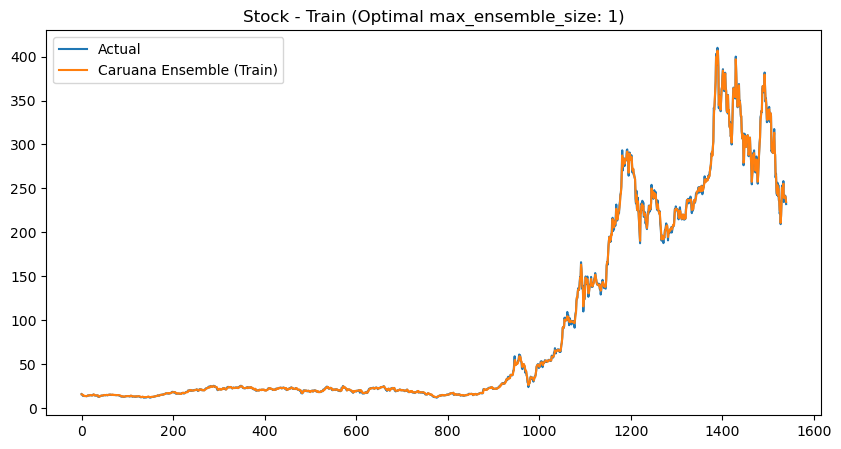

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, label="Actual")
plt.plot(ensemble_preds_train, label="Caruana Ensemble (Train)")
plt.title(f"{selected_dataset.title()} - Train (Optimal max_ensemble_size: {best_max_ensemble_size})")
plt.legend()
plt.show()

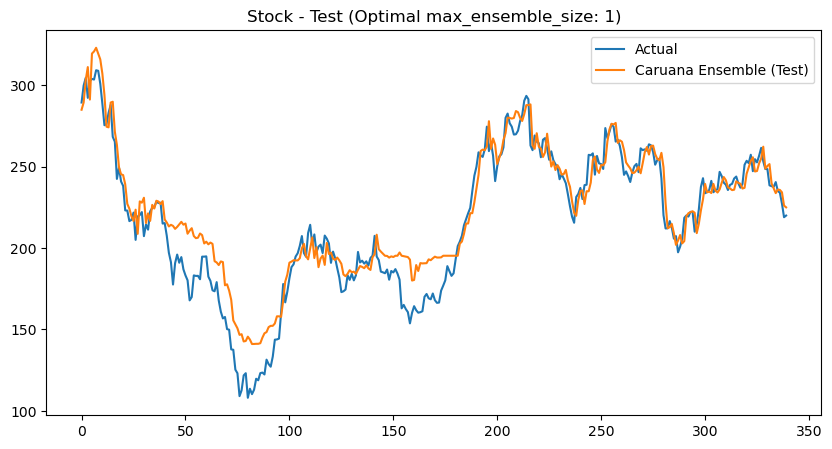

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(ensemble_preds_test, label="Caruana Ensemble (Test)")
plt.title(f"{selected_dataset.title()} - Test (Optimal max_ensemble_size: {best_max_ensemble_size})")
plt.legend()
plt.show()

In [29]:
model_rmses = []
for model in selected_models:
    with open(f"{model}/RMSE_{model}.json", "r") as f:
        rmse_data = json.load(f)
    model_rmses.append(rmse_data[selected_dataset])
model_rmses.append(rmse_test)

labels = [m for m in selected_models] + ['Caruana Ensemble']

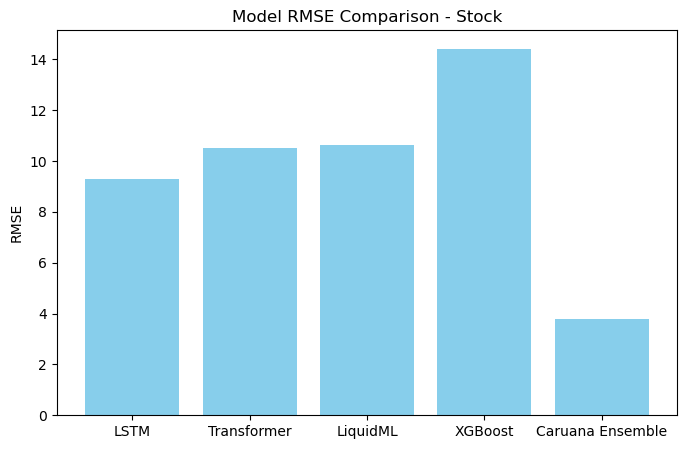

In [30]:
plt.figure(figsize=(8, 5))
plt.bar(labels, model_rmses, color='skyblue')
plt.title(f"Model RMSE Comparison - {selected_dataset}")
plt.ylabel("RMSE")
plt.show()